In [1]:
import pickle
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from model import SugarscapeCg
from agents import Cop, Criminal
from scipy import stats
from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

In [2]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

## Helper functions

In [3]:
def run_model(model, step_count=300):
    """
    Runs the model and returns the output.
    """
    model.run_model(step_count=step_count)
    output = model.datacollector.get_model_vars_dataframe()
    return output 

In [4]:
def get_data(df, key):
    """ 
    Transposes and returns the data from a dataframe given a key.
    """
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [5]:
def get_means_cis(data):
    """
    Returns the means and 95% confidence intervals of the input data.
    """
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [6]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    """
    Returns the average number of crimes
    and the bounds of the 95% confidence interval.
    """
    avg_crimes_per_distr_dict = {
        'Centrum': 0, 
        'Nieuw-West': 0, 
        'Noord': 0, 
        'Oost': 0, 
        'West': 0, 
        'Zuid': 0, 
        'Zuidoost': 0
    } 
    confidence_bounds = dict()
    means_dict_for_ci = {}
    
    # obtain the means
    for i in range(len(outputs)):
        for district in district_names:
            district_mean = np.mean(outputs[i].iloc[burn_in:][district])
            avg_crimes_per_distr_dict[district] += district_mean
            if district in means_dict_for_ci.keys():
                means_dict_for_ci[district].append(district_mean)
            else:
                means_dict_for_ci[district] = [district_mean]
    
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    avg_crimes_per_distr_dict = dict(
        sorted(avg_crimes_per_distr_dict.items(), 
        key=lambda item:item[1])
    )
    
    # obtain the confidence intervals
    for district in avg_crimes_per_distr_dict.keys():
        confidence_bounds[district] = (
            1.96 * np.std(means_dict_for_ci[district]) 
            / len(means_dict_for_ci[district])
        )

    return avg_crimes_per_distr_dict, confidence_bounds

In [7]:
def zipf(height):
    """
    Returns x, y values following zipf's law given a starting height 
    and x values between 0 and 6.
    """
    x = np.linspace(1, 7, 1000)
    y = height / x
    y = np.flip(y)
    x = np.linspace(0, 6, 1000)
    return x, y

In [8]:
def ks_test(avg_crimes_per_district_dict, visual=False):
    """
    Returns a Kolmogorov-Smirnov test between 
    the average number of crimes in each distract and zipf's law.
    """

    # average crimes placed in list
    avg_per_district = list(avg_crimes_per_district_dict.values())
    x_avg = np.linspace(0, 1, len(avg_per_district))

    # values follwoing zipf law with same max
    zipf_list = zipf(max(avg_per_district))[1]
    x_zipf = np.linspace(0, 1, len(zipf_list))

    # visual comparison of cdf's
    if visual:
        plt.plot(
            x_avg, 
            np.cumsum(avg_per_district) / sum(avg_per_district), 
            label='districts'
        )
        plt.plot(x_zipf, np.cumsum(zipf_list) / sum(zipf_list), label='zipf')
        plt.legend()
        plt.show()

    # if the p-value is low, reject null-hypothesis that they are identical
    test = stats.kstest(avg_per_district, zipf_list) 
    return test

In [9]:
def get_averages_for_normality_test(output_dict):
    """"
    This function returns the n average crimes 
    within a district for all districts.
    """
    avg_crimes_per_distr_dict = {
        'Centrum': [], 
        'Nieuw-West': [], 
        'Noord': [], 
        'Oost': [], 
        'West': [], 
        'Zuid': [], 
        'Zuidoost': []
    } 
    for district in avg_crimes_per_distr_dict.keys():
        for i in output_dict.keys():
            avg_crimes_per_distr_dict[district].append(
                np.mean(output_dict[i].iloc[100:][district])
            )
    return avg_crimes_per_distr_dict

In [10]:
def normality_test(district_averages):
    """"
    This function performs a normality test for the averages within a district, 
    for each district and returns the p-value the normality test. 
    Here we use scipy.stats.normaltest(). 
    The p values are returned in the form of a dictionary 
    with the district names as keys. 
    """
    normality_p_vals_districts = {
        'Centrum': 0, 
        'Nieuw-West': 0, 
        'Noord': 0, 
        'Oost': 0, 
        'West': 0, 
        'Zuid': 0, 
        'Zuidoost': 0
    }
    for district in district_averages.keys():
        p = stats.normaltest(district_averages[district])[1]
        normality_p_vals_districts[district] = p
    return normality_p_vals_districts

## Plotting functions

In [11]:
def plot_errorbars(means, cis, y_axis_label):
    """
    Produces a plot with error bars. 
    """
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [12]:
def plot_district_crimes(
    district_means, 
    district_cis, 
    district_names, 
    district_colors
):
    """
    Produces a colorcoded plot of the mean number of crimes 
    along with their error bars.
    """
    for district_index in range(len(district_means)):
        plt.errorbar(
            x=range(len(district_means[district_index])), 
            y=district_means[district_index], 
            yerr=district_cis[district_index], 
            label=district_names[district_index], 
            color=district_colors[district_index], 
            ecolor=district_colors[district_index]
        )
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [13]:
def plot_district_means_bar(
    avg_crimes_per_distr_dict, 
    district_colors,
    confidence_bounds,
    filename
):
    """
    Produces of a bar plot of the mean number of crimes in each distrcit 
    along with their 95% confidence interval.
    """  
    plt.bar(
        avg_crimes_per_distr_dict.keys(), 
        avg_crimes_per_distr_dict.values(), 
        yerr=confidence_bounds.values(), 
        color=district_colors, 
        capsize=10
    )
    ct = datetime.datetime.now().strftime('%d-%m-%Y %H %M %S')
    name = filename + ct + '.jpeg'
    plt.savefig(name,dpi='figure')
    plt.show()
    return

In [14]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

In [15]:
def plot_averages_for_normality_test(district_averages, bin_width):
    """"
    This function plots the distribution 
    of the sample of average crimes within a district.
    """
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
    for district,colour in zip(district_averages.keys(),colors):
        bins = np.arange(
            np.min(district_averages[district]), 
            np.max(district_averages[district])+bin_width, bin_width
        )
        sns.distplot(district_averages[district], bins=bins, color=colour)
        plt.title("Crime Distribution of " + district)
        plt.xlabel("Average Crimes Commited")
        name = district + "_distribution_plot" + '.jpeg'
        plt.savefig(name,dpi='figure')
        plt.show()
    return

In [16]:
def QQ_plots(district_averages):
    """"
    This function plots the Quantile-Quantile plots 
    of the sample of average crimes within a district.
    """
    for district in district_averages.keys():
        sm.qqplot(np.array(district_averages[district]),line='q')
        name = district + "_QQplot_" + '.jpeg'
        plt.savefig(name,dpi='figure')
        plt.title("QQ plot of " + district)
        plt.show()
    return

# Sensitivity Analysis

In [ ]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': [
        'jail_sentence', 
        'criminal_risk_radius', 
        'cop_catch_radius', 
        'criminal_risk_aversion', 
        'criminal_disconnectivity'
    ],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": 
    lambda m: 
    m.schedule.get_crimes_commited(), 

    "Criminals in jail": 
    lambda m: 
    m.schedule.get_criminal_count_in_jail(),

    "Centrum": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),

    "Noord": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),

    "West": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("West").get("West"),

    "Zuid": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),

    "Zuidoost": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),

    "Oost": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    
    "Nieuw-West": 
    lambda m:
    m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}

# Set the repetitions, the amount of steps, 
# and the amount of distinct values per variable
replicates = 1
max_steps = 300
distinct_samples = 500

param_values = saltelli.sample(
    problem, 
    N=distinct_samples, 
    calc_second_order=False
)

# Round and cast param_values to integers
param_values_rounded = [np.rint(row).astype(int) for row in param_values]
param_values = param_values_rounded

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

In [ ]:
# Create dataframe
count = 0
data = pd.DataFrame(
    index=range(replicates*len(param_values)), 
    columns=[
        'jail_sentence', 
        'criminal_risk_radius', 
        'cop_catch_radius', 
        'criminal_risk_aversion', 
        'criminal_disconnectivity'
    ]
)

data['Run'] = None
data['Centrum'] = None
data['Criminals in jail'] = None
data['Nieuw-West'] = None
data['Noord'] = None
data['Oost'] = None
data['Total crimes'] = None
data['West'] = None
data['Zuid'] = None
data['Zuidoost'] = None

for i in range(replicates):
    for vals in param_values: 
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count)

        # fills in varied parameter
        data.iloc[count, :len(problem['names'])] = vals  
        # fills in output data
        data.iloc[count, len(problem['names']):] = iteration_data  
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

In [ ]:
# print and save the data
print(data)
ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

In [ ]:
# print a copy of the date with zeroed rows
data_cp = data.copy()
while data_cp.shape[0] != 3500:
    data_cp = data_cp.append(
        pd.Series(0, index=data_cp.columns), 
        ignore_index=True
    )
print(data_cp)

In [ ]:
# run analyses
Si_crimes = sobol.analyze(
    problem,
     data['Total crimes'].values, 
     calc_second_order=False, 
     print_to_console=True
)
Si_jail = sobol.analyze(
    problem, 
    data['Criminals in jail'].values, 
    calc_second_order=False,
    print_to_console=True
)
Si_centrum = sobol.analyze(
    problem, 
    data['Centrum'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_noord = sobol.analyze(
    problem, data['Noord'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_west = sobol.analyze(
    problem, 
    data['West'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_zuid = sobol.analyze(
    problem, data['Zuid'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_zuidoost = sobol.analyze(
    problem, 
    data['Zuidoost'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_oost = sobol.analyze(
    problem, 
    data['Oost'].values, 
    calc_second_order=False, 
    print_to_console=True
)
Si_nieuw_west = sobol.analyze(
    problem, 
    data['Nieuw-West'].values, 
    calc_second_order=False, 
    print_to_console=True
)

In [ ]:
# show the result of the analyses
for Si in (
   Si_crimes, 
   Si_jail, 
   Si_centrum, 
   Si_noord, 
   Si_west, 
   Si_zuid, 
   Si_zuidoost, 
   Si_oost, 
   Si_nieuw_west
):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Experiments

## Baseline

In [19]:
num_runs = 50
output_dict_baseline = {}
val = 0

for run in range(num_runs):
    clear_output()
    print(f"Run {run+1}/{num_runs}")

    # run the experiment
    m = SugarscapeCg()

    # get output
    output = run_model(m)

    # save output in dict
    if val in output_dict_baseline:
        output_dict_baseline[val].append(output)
    else:
        output_dict_baseline[val] = [output]

Run 2/2


In [20]:
# save a copy of the output
with open('experiment_outputs/experiment_output_baseline.pkl', 'wb') as f:
    pickle.dump(output_dict_baseline, f)

Baseline 0
KstestResult(statistic=0.4602857142857143, pvalue=0.07249870219475596)


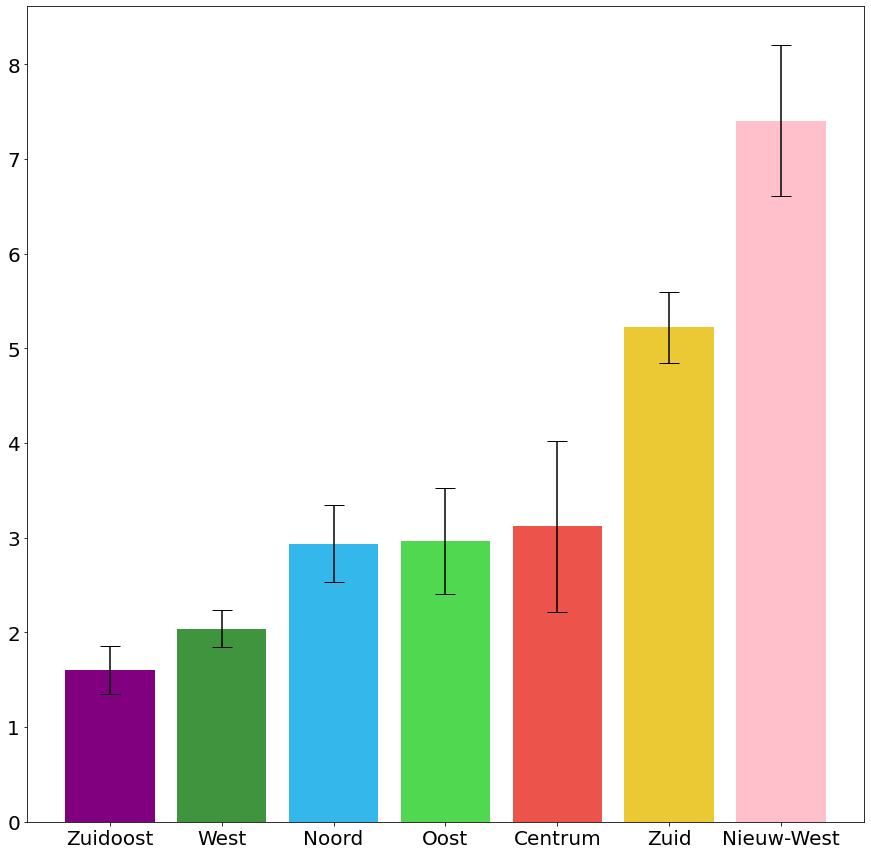

In [21]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict_baseline:

    # get the average crimes and their confidence intervals
    avg_crimes_per_distr_dict_baseline, confidence_bounds_baseline = (
        get_average_crime_per_distr(
            output_dict_baseline[keys], 
            district_names, 100
        )
    )

    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_baseline.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Baseline {keys}")

    # perform a ks test
    print(ks_test(avg_crimes_per_distr_dict_baseline))

    # plot the results 
    plot_district_means_bar(
        avg_crimes_per_distr_dict_baseline, 
        district_colors,
        confidence_bounds_baseline, 
        f"baseline_{keys}_"
    )

## Criminal disconnectivity experiment

In [22]:
num_runs = 50
outputs = []
output_dict = {}

criminal_disconnectivities = [0, 25, 75, 100]

for val in criminal_disconnectivities:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_disconnectivity=val)
        output = run_model(m)
        if val in output_dict:
            output_dict[val].append(output)
        else:
            output_dict[val] = [output]

Run 2/2 of value 100


In [23]:
with open('experiment_outputs/experiment_output_cd.pkl', 'wb') as f:
    pickle.dump(output_dict, f)

Criminal disconnectivity 0
KstestResult(statistic=0.7142857142857143, pvalue=0.00041974666726851684)


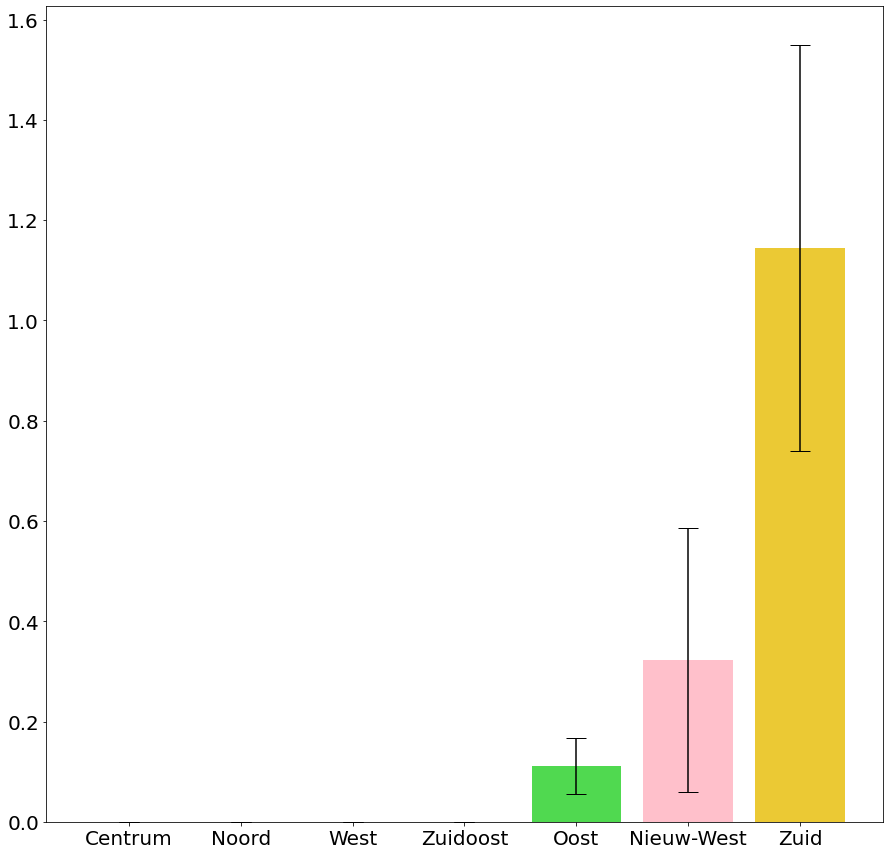

Criminal disconnectivity 25
KstestResult(statistic=0.6761428571428572, pvalue=0.0011439887713323715)


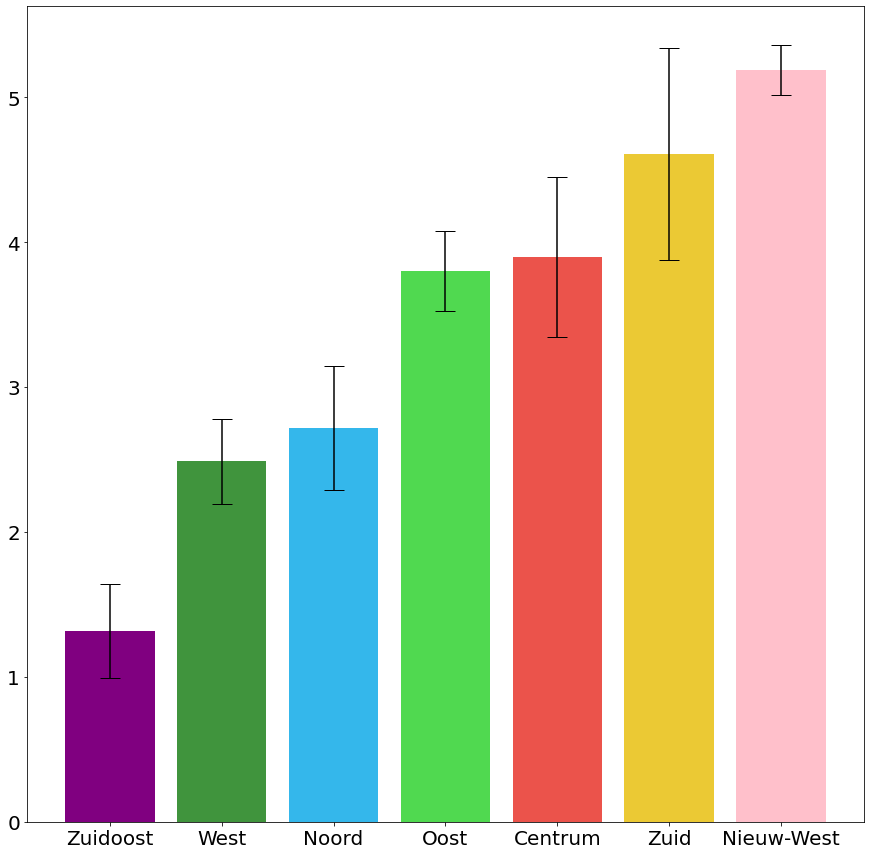

Criminal disconnectivity 75
KstestResult(statistic=0.4132857142857143, pvalue=0.13725679630453946)


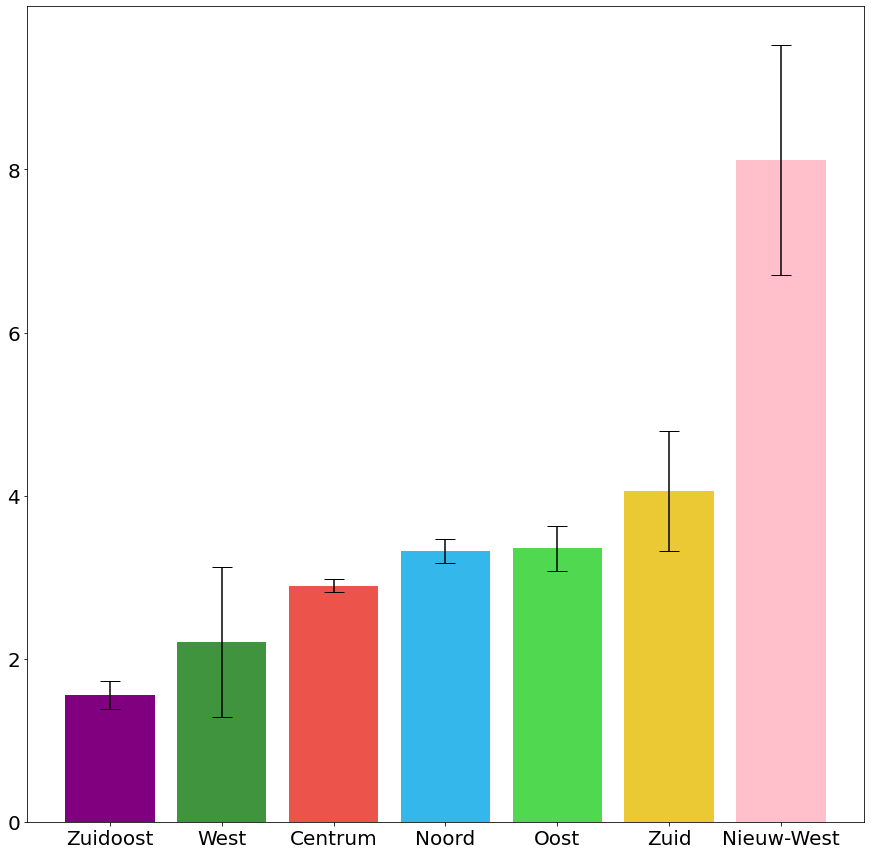

Criminal disconnectivity 100
KstestResult(statistic=0.5351428571428571, pvalue=0.0219042830049887)


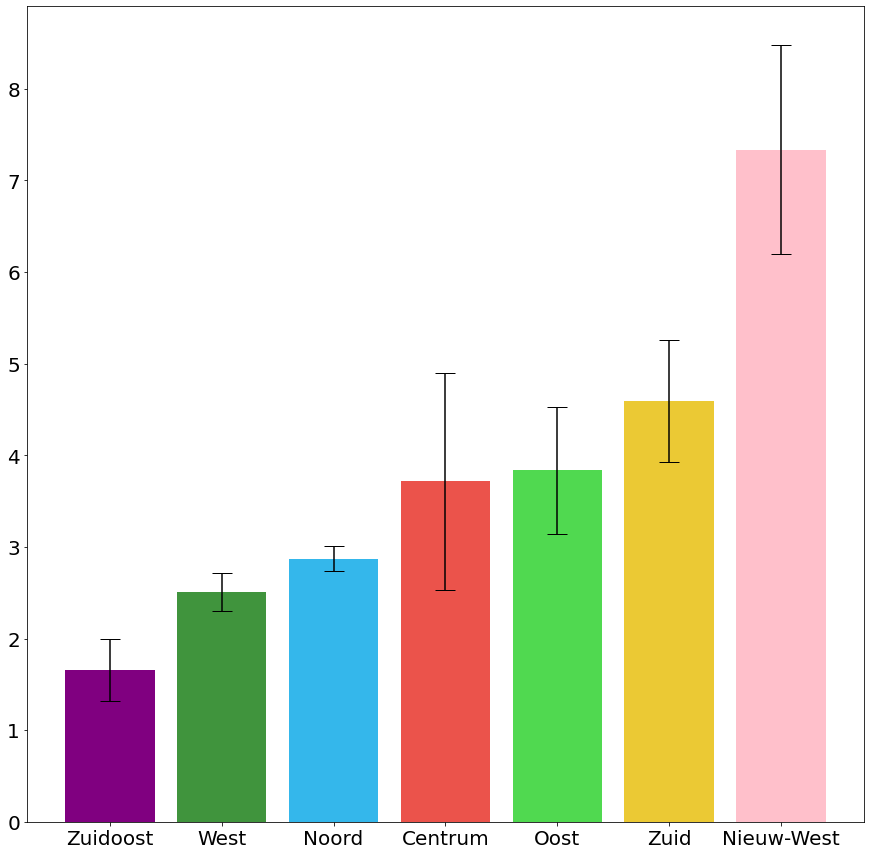

In [24]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict:
    avg_crimes_per_distr_dict_cd, confidence_bounds = (
        get_average_crime_per_distr(
            output_dict[keys], 
            district_names, 
            100
        )
    )
    district_colors = []
    for district in avg_crimes_per_distr_dict_cd.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal disconnectivity {keys}")
    print(ks_test(avg_crimes_per_distr_dict_cd))
    plot_district_means_bar(
        avg_crimes_per_distr_dict_cd, 
        district_colors,confidence_bounds,
        f"criminaldisconnectivity_{keys}_"
    )

## Criminal risk aversion

In [25]:
num_runs = 50
output_dict_ra = {}
criminal_risk_aversions = [0, 10, 100, 500]

for val in criminal_risk_aversions:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_aversion=val)
        output = run_model(m)
        if val in output_dict_ra:
            output_dict_ra[val].append(output)
        else:
            output_dict_ra[val] = [output]

Run 2/2 of value 500


In [26]:
with open('experiment_outputs/experiment_output_ra.pkl', 'wb') as f:
    pickle.dump(output_dict_ra, f)

Criminal risk aversion 0
KstestResult(statistic=0.42857142857142855, pvalue=0.1123734381593281)


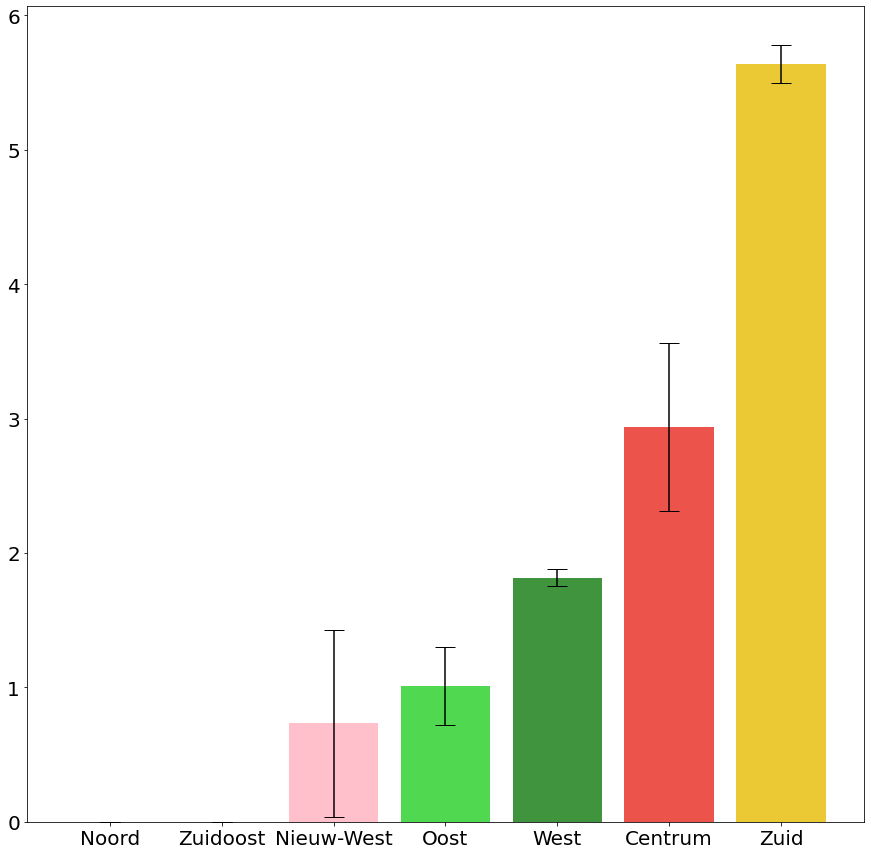

Criminal risk aversion 10
KstestResult(statistic=0.4052857142857143, pvalue=0.15181343817976334)


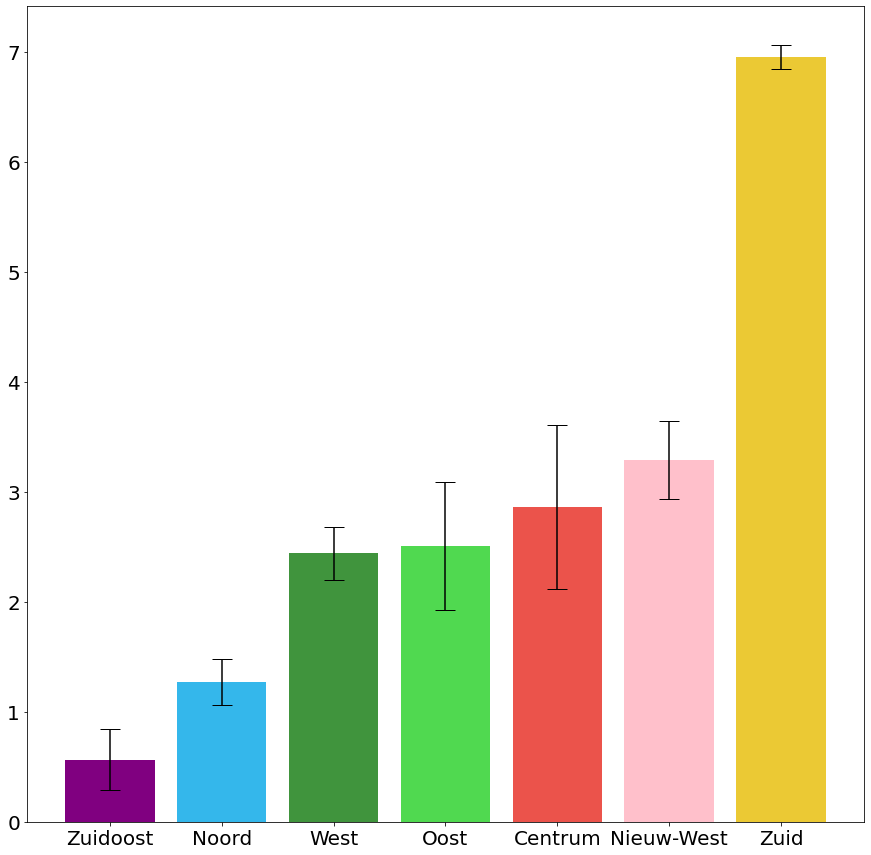

Criminal risk aversion 100
KstestResult(statistic=0.29828571428571427, pvalue=0.4769324707985032)


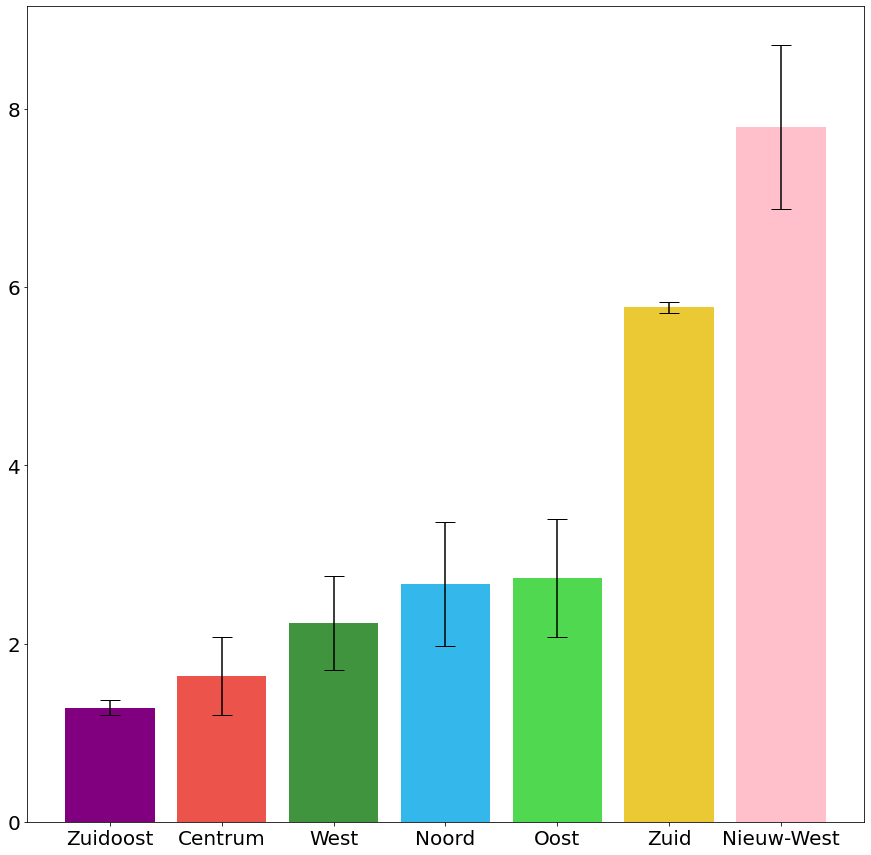

Criminal risk aversion 500
KstestResult(statistic=0.438, pvalue=0.09961101411486284)


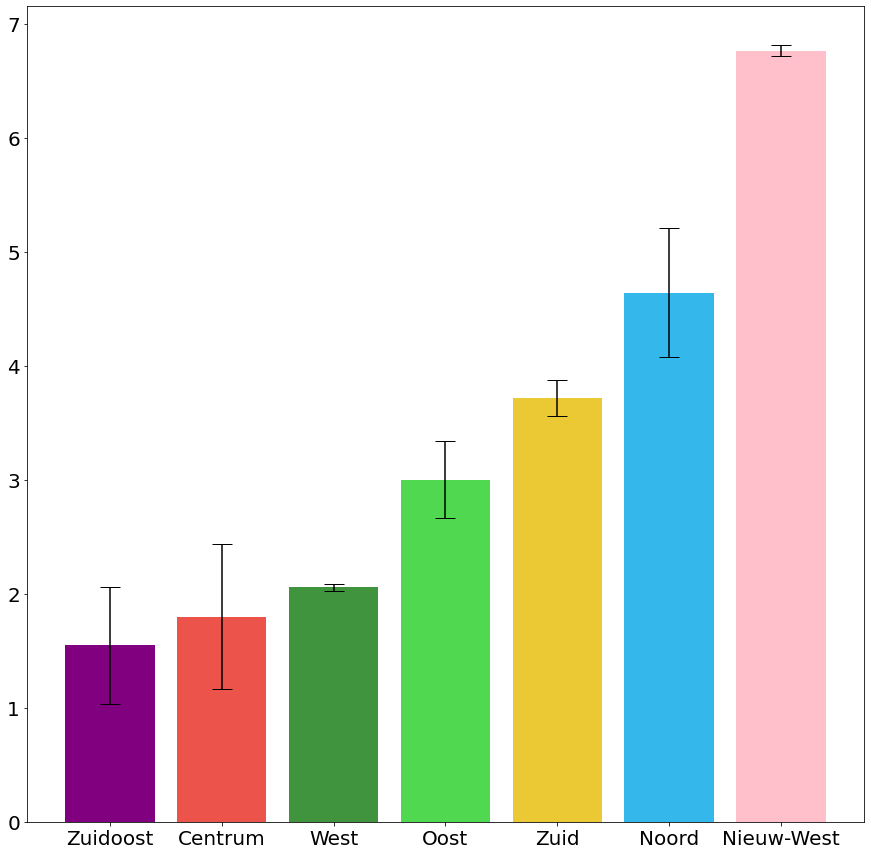

In [27]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict_ra:
    avg_crimes_per_distr_dict_ra, confidence_bounds_ra = (
        get_average_crime_per_distr(
            output_dict_ra[keys], 
            district_names, 
            100
        )
    )
    district_colors = []
    for district in avg_crimes_per_distr_dict_ra.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal risk aversion {keys}")
    print(ks_test(avg_crimes_per_distr_dict_ra))
    plot_district_means_bar(
        avg_crimes_per_distr_dict_ra, 
        district_colors,
        confidence_bounds_ra, 
        f"riskaversion_{keys}_"
    )


## Jail sentence

In [28]:
num_runs = 50
output_dict_jt = {}
jail_sentences = [0, 5, 10, 20]

for val in jail_sentences:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(jail_sentence=val)
        output = run_model(m)
        if val in output_dict_jt:
            output_dict_jt[val].append(output)
        else:
            output_dict_jt[val] = [output]

Run 2/2 of value 20


In [29]:
with open('experiment_outputs/experiment_output_jt.pkl', 'wb') as f:
    pickle.dump(output_dict_jt, f)

Jail sentence 0
KstestResult(statistic=0.6, pvalue=0.006444853184572441)


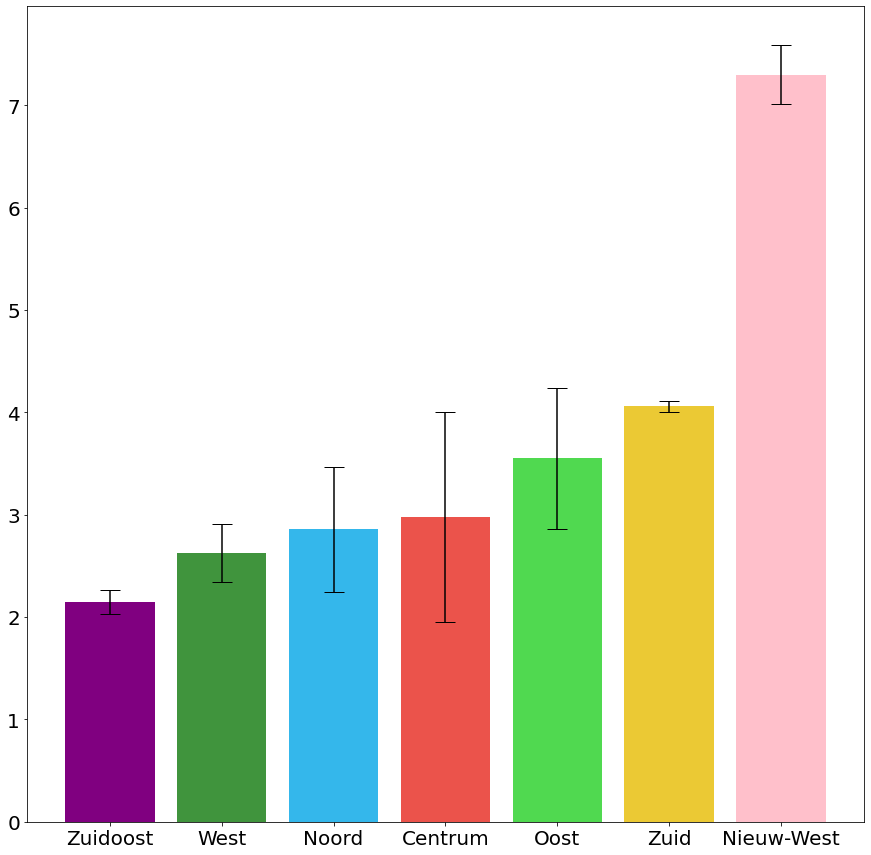

Jail sentence 5
KstestResult(statistic=0.5061428571428571, pvalue=0.035750834052600045)


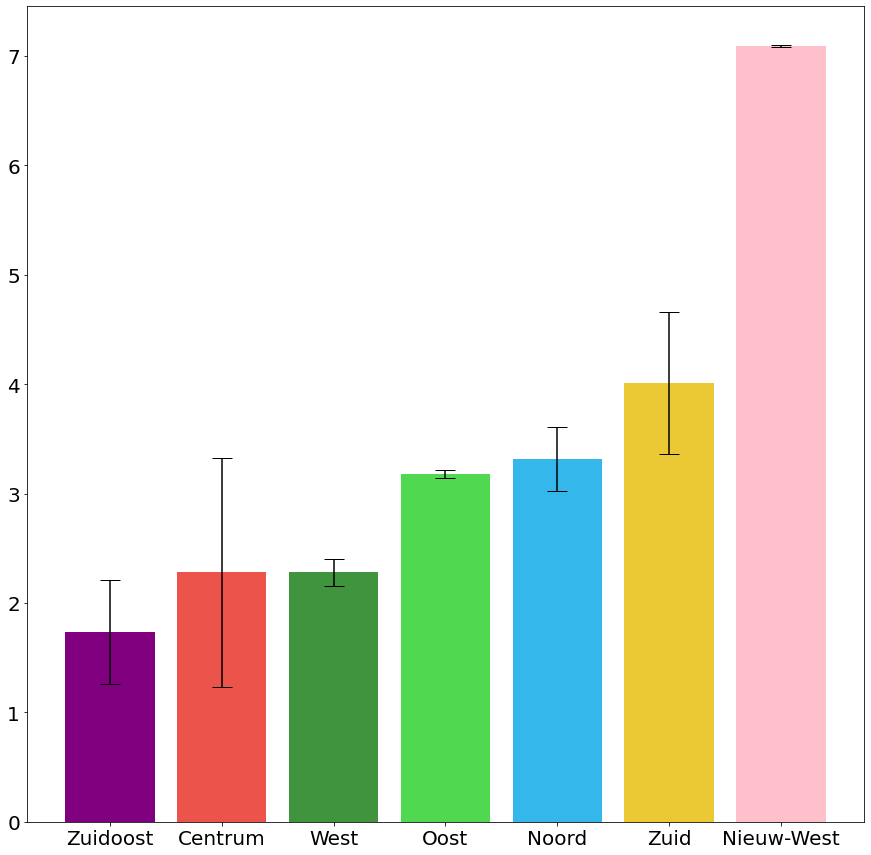

Jail sentence 10
KstestResult(statistic=0.6201428571428571, pvalue=0.004183953772191384)


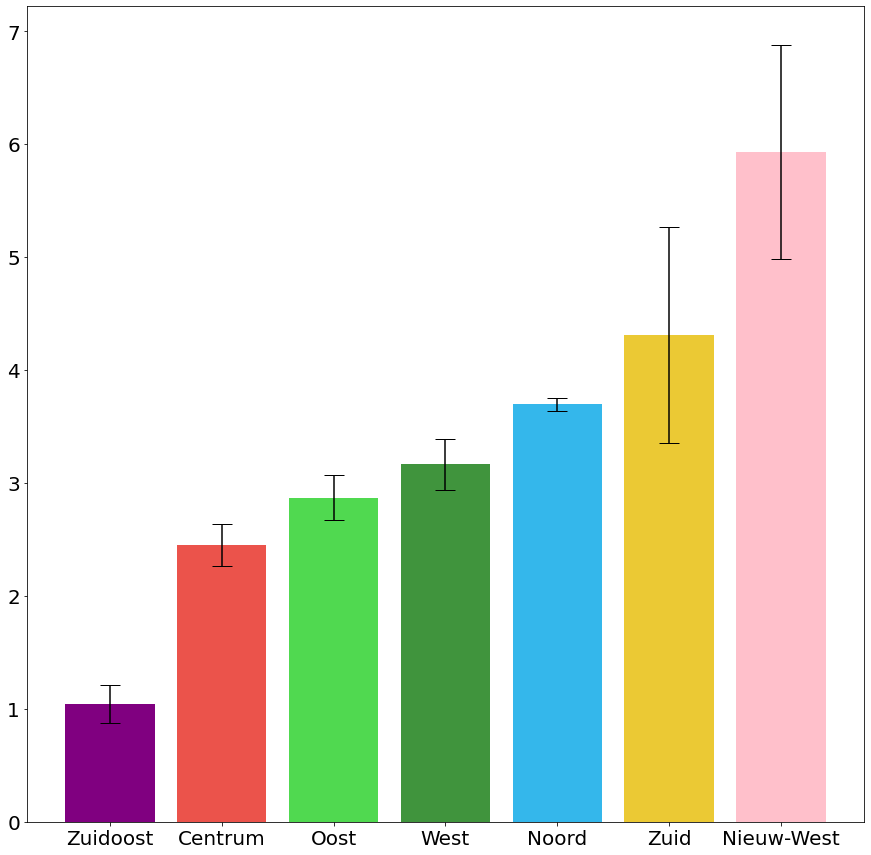

Jail sentence 20
KstestResult(statistic=0.6981428571428572, pvalue=0.000652691503452929)


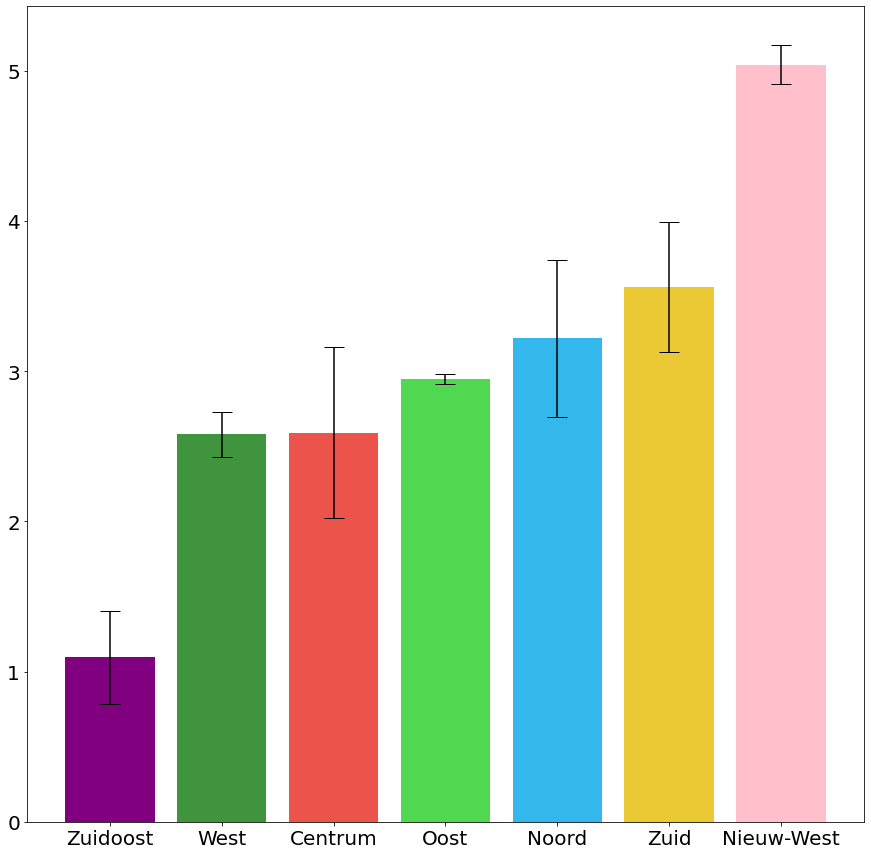

In [30]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict_jt:
    avg_crimes_per_distr_dict_jt, confidence_bounds_jt = (
        get_average_crime_per_distr(
            output_dict_jt[keys], 
            district_names, 
            100
        )
    )
    district_colors = []
    for district in avg_crimes_per_distr_dict_jt.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Jail sentence {keys}")
    print(ks_test(avg_crimes_per_distr_dict_jt))
    plot_district_means_bar(
        avg_crimes_per_distr_dict_jt, 
        district_colors,confidence_bounds_jt, 
        f"jailsentence_{keys}_"
    )

## Criminal Risk Radius

In [31]:
num_runs = 50
output_dict_crr = {}
criminal_risk_radiuses = [1, 2, 5, 10]

for val in criminal_risk_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_radius=val)
        output = run_model(m)
        if val in output_dict_crr:
            output_dict_crr[val].append(output)
        else:
            output_dict_crr[val] = [output]

Run 2/2 of value 10


In [32]:
with open('experiment_outputs/experiment_output_crr.pkl', 'wb') as f:
    pickle.dump(output_dict_crr, f)

Criminal Risk Radius 1
KstestResult(statistic=0.5714285714285714, pvalue=0.01123654344998637)


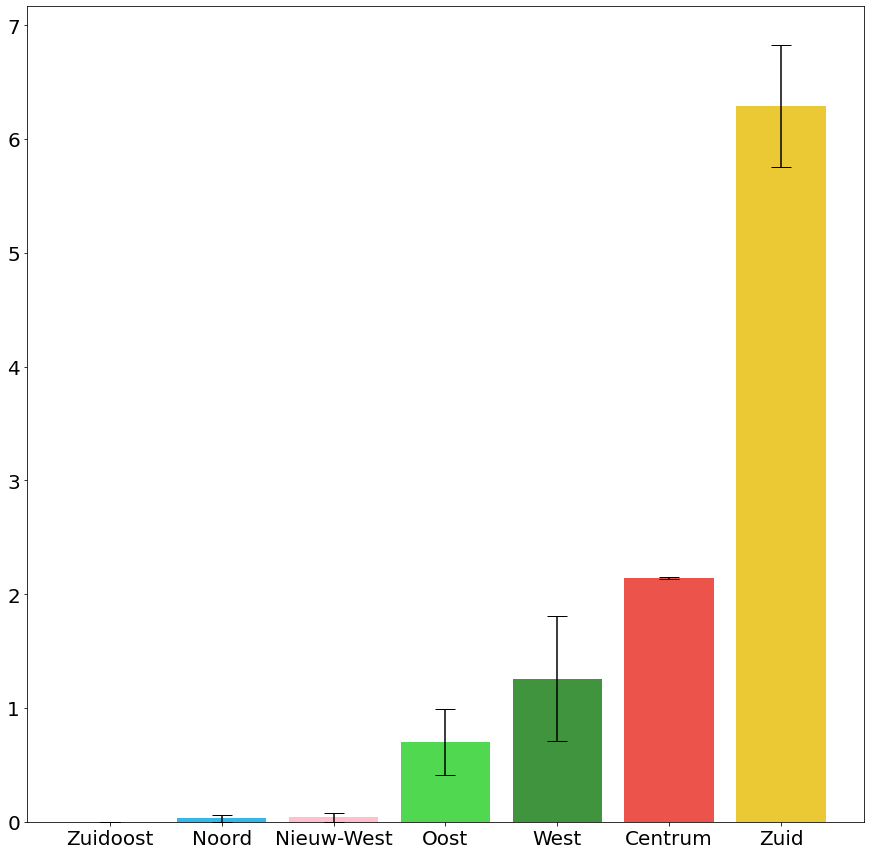

Criminal Risk Radius 2
KstestResult(statistic=0.5474285714285714, pvalue=0.01751427380321946)


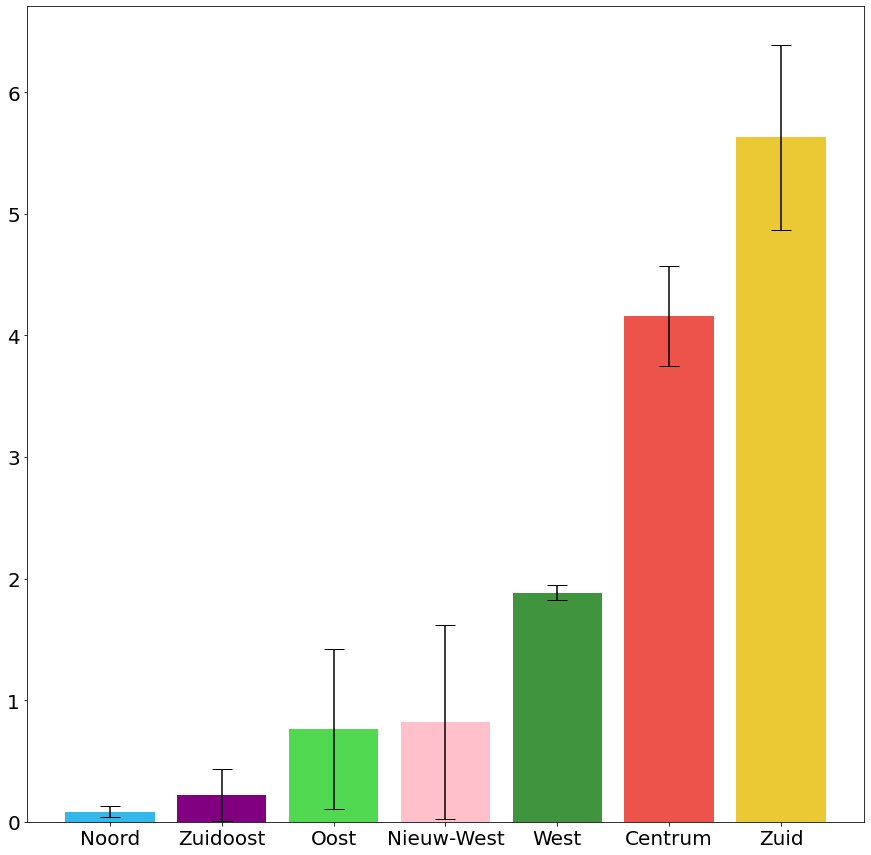

Criminal Risk Radius 5
KstestResult(statistic=0.5701428571428572, pvalue=0.011591462728252844)


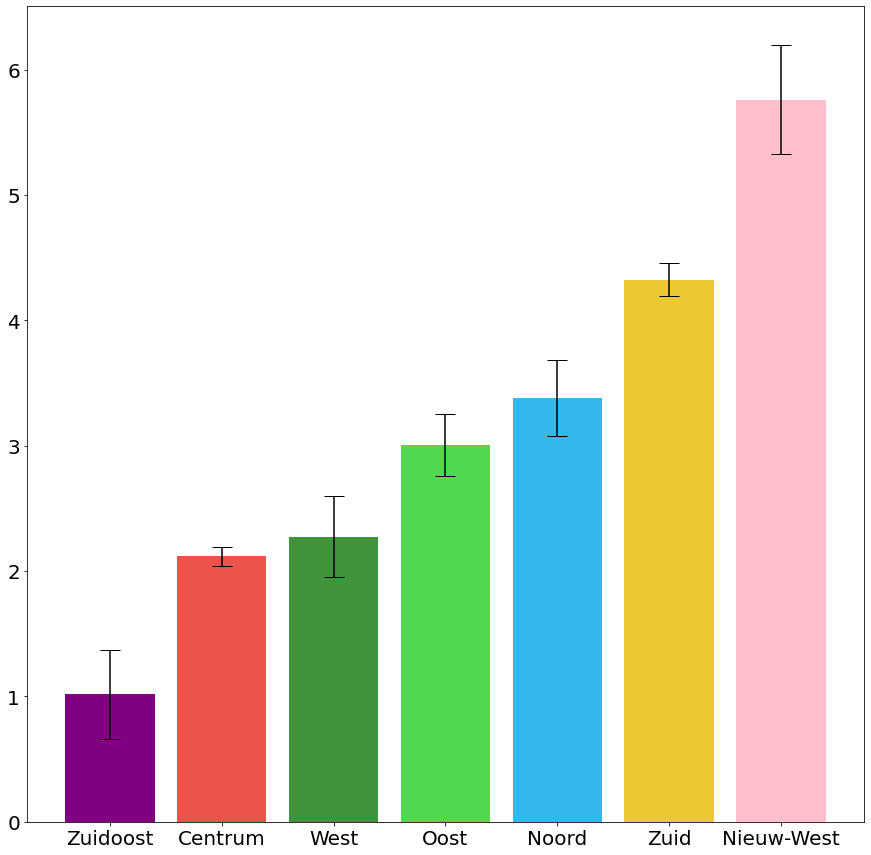

Criminal Risk Radius 10
KstestResult(statistic=0.31642857142857145, pvalue=0.40518788082460133)


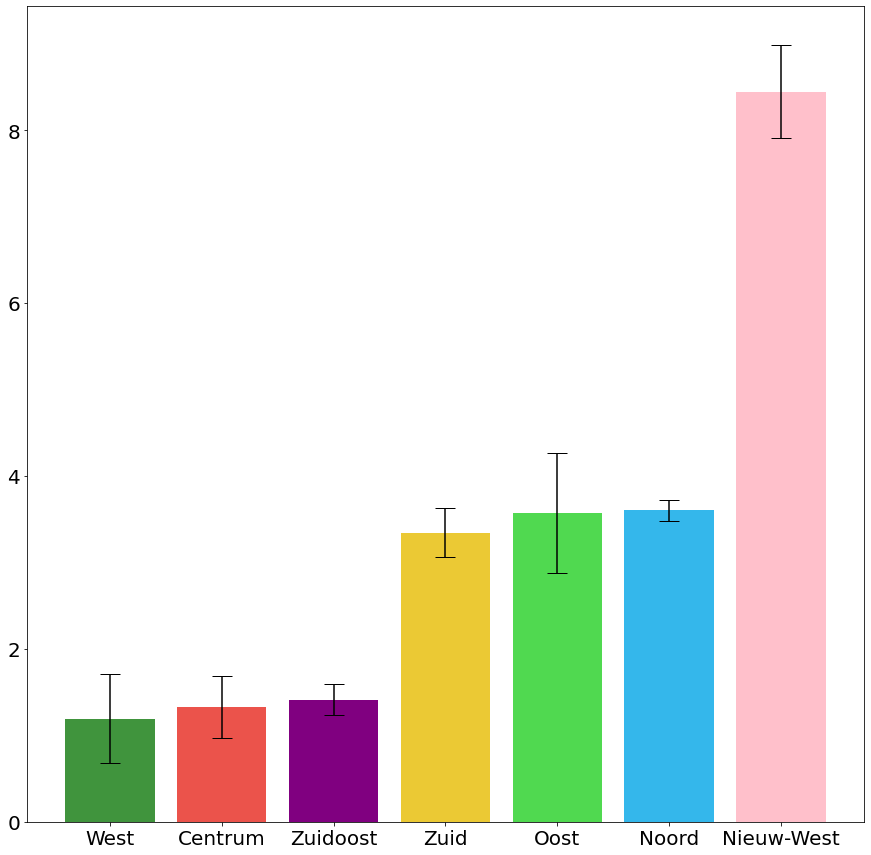

In [33]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict_crr:
    avg_crimes_per_distr_dict_crr, confidence_bounds_crr = (
        get_average_crime_per_distr(
            output_dict_crr[keys], 
            district_names, 
            100
        )
    )
    district_colors = []
    for district in avg_crimes_per_distr_dict_crr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal Risk Radius {keys}")
    print(ks_test(avg_crimes_per_distr_dict_crr))
    plot_district_means_bar(
        avg_crimes_per_distr_dict_crr, 
        district_colors,confidence_bounds_crr, 
        f"criminalriskradius_{keys}_"
    )


## Cop Catch Radius

In [34]:
num_runs = 50
output_dict_cocr = {}
cop_catch_radiuses = [1, 2, 5, 10]

for val in cop_catch_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(cop_catch_radius=val)
        output = run_model(m)
        if val in output_dict_cocr:
            output_dict_cocr[val].append(output)
        else:
            output_dict_cocr[val] = [output]

Run 2/2 of value 10


In [35]:
with open('experiment_outputs/experiment_output_cocr.pkl', 'wb') as f:
    pickle.dump(output_dict_cocr, f)

Cop Catch Radius 1
KstestResult(statistic=0.35214285714285715, pvalue=0.28305452658876495)


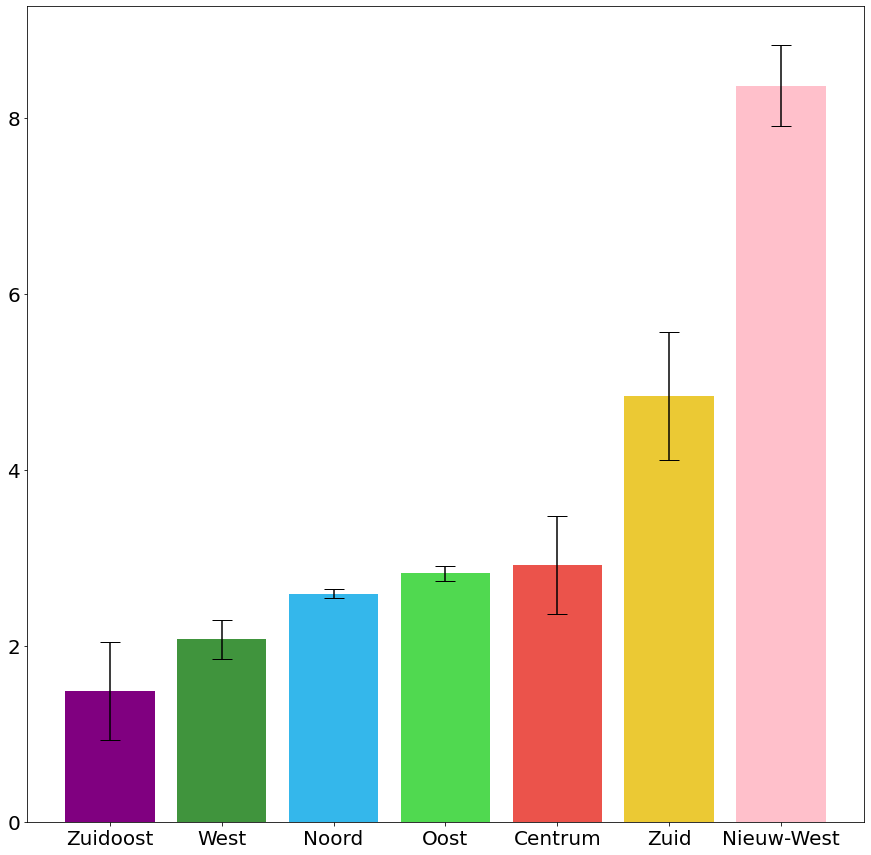

Cop Catch Radius 2
KstestResult(statistic=0.46414285714285713, pvalue=0.06869949393133967)


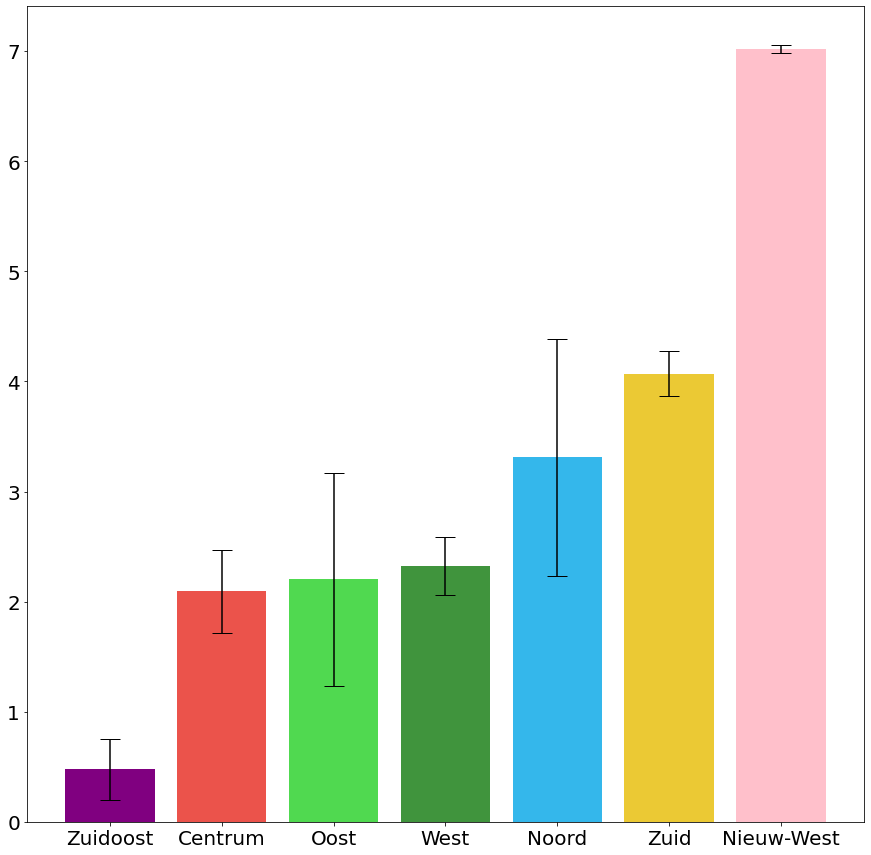

Cop Catch Radius 5
KstestResult(statistic=0.5562857142857143, pvalue=0.014940725385700349)


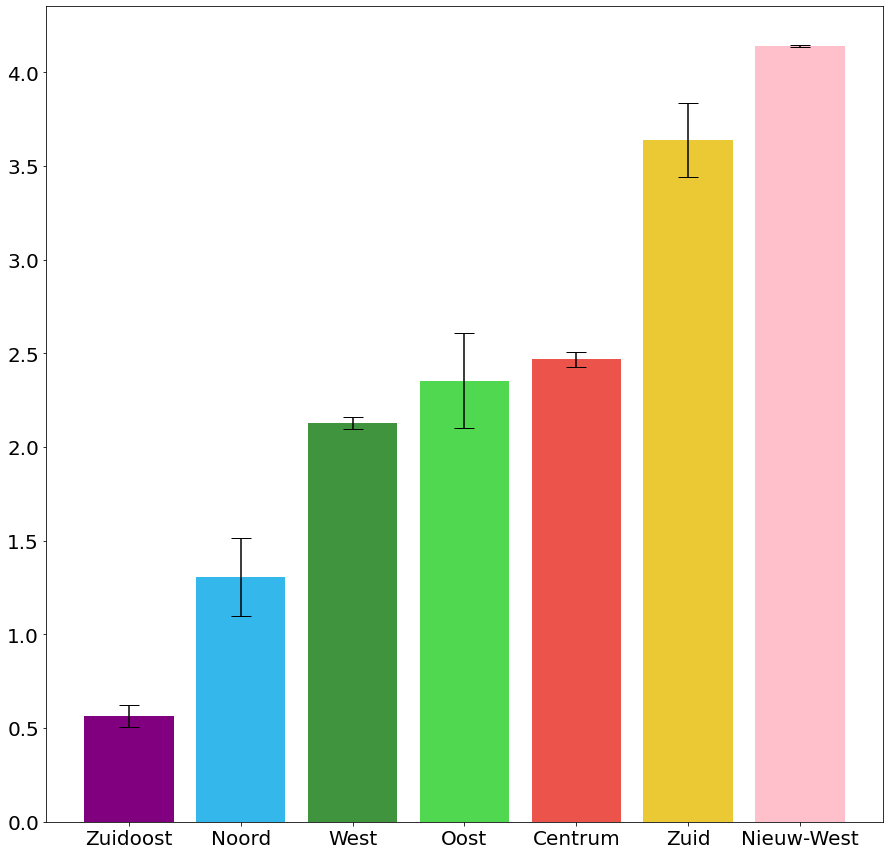

Cop Catch Radius 10
KstestResult(statistic=0.4154285714285714, pvalue=0.13334863813384823)


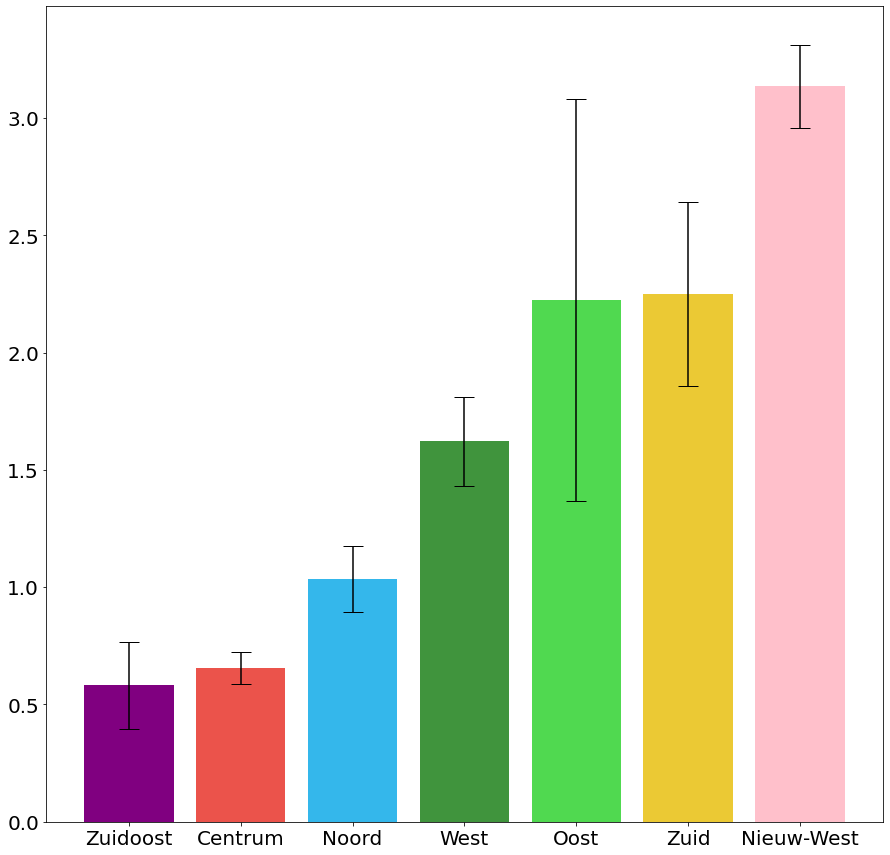

In [36]:
district_names = [
    'Centrum', 
    'Noord', 
    'West', 
    'Zuid', 
    'Zuidoost', 
    'Oost', 
    'Nieuw-West'
]

districts_dict = [
    {"Label": "Centrum", "Color": "#eb534b"},
    {"Label": "Noord", "Color": "#34b7eb"},
    {"Label": "West", "Color": "#40943d"},
    {"Label": "Nieuw-West", "Color": "#ffc0cb"},
    {"Label": "Zuid", "Color": "#ebc934"},
    {"Label": "Oost", "Color": "#50d950"},
    {"Label": "Zuidoost", "Color": "#800080"}
]

for keys in output_dict_cocr:
    avg_crimes_per_distr_dict_cocr, confidence_bounds_cocr = (
        get_average_crime_per_distr(
            output_dict_cocr[keys], 
            district_names, 100
        )
    )
    district_colors = []
    for district in avg_crimes_per_distr_dict_cocr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Cop Catch Radius {keys}")
    print(ks_test(avg_crimes_per_distr_dict_cocr))
    plot_district_means_bar(
        avg_crimes_per_distr_dict_cocr, 
        district_colors,
        confidence_bounds_cocr, 
        f"copcatchradius_{keys}_"
    )

# Normality tests

In [17]:
# run a baseline experiment
num_runs = 200
output_dict_baseline = {}
for run in range(num_runs):
    clear_output()
    print(f"Run {run+1}/{num_runs}")
    m = SugarscapeCg()
    output = run_model(m)
    output_dict_baseline[run] = output

# obtain the averages per district
district_averages = get_averages_for_normality_test(output_dict_baseline)

# calculate the p-values
normality_p_vals_districts = normality_test(district_averages)

# check for normality
for district in normality_p_vals_districts.keys():
    if normality_p_vals_districts[district] < 0.05:
        print(
            f"The null hypothesis for normality is rejected for district",
            f"{district} with p value {normality_p_vals_districts[district]}"
        )
    else:
        print(
            f"The null hypothesis for normality is NOT rejected for district",
            f"{district} with p value {normality_p_vals_districts[district]}"
        )

# plot the averages
plot_averages_for_normality_test(district_averages,0.25)

# produce QQ plots
QQ_plots(district_averages)


Run 2/200
